In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import t

In [2]:
data=pd.read_csv('QVI_data.csv')

## Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [28]:
#Re-examine the data cleaning
from ydata_profiling import ProfileReport
profile=ProfileReport(data)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

# Step 1: Create a month ID
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Step 2: Define the measure calculations
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / data.loc[x.index, 'TXN_ID'].nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Step 3: Filter stores with full observation periods (12 months of data)
stores_with_full_obs = (
    measure_over_time.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()
)

# Step 4: Filter to pre-trial period data and stores with full observation periods
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) &
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))
]

print(pre_trial_measures)

      STORE_NBR  YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0             1     201807     206.9          49     1.061224      1.192308   
1             1     201808     176.1          42     1.023810      1.255814   
2             1     201809     278.8          59     1.050847      1.209677   
3             1     201810     188.1          44     1.022727      1.288889   
4             1     201811     192.6          46     1.021739      1.212766   
...         ...        ...       ...         ...          ...           ...   
3159        272     201809     304.7          32     1.125000      1.972222   
3160        272     201810     430.6          44     1.136364      1.980000   
3161        272     201811     376.2          41     1.097561      1.933333   
3162        272     201812     403.9          47     1.000000      1.893617   
3163        272     201901     423.0          46     1.086957      1.920000   

      avgPricePerUnit  
0            3.337097  
1  

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [5]:
def calculate_correlation(input_table, metric_col, store_comparison):
    """
    Calculate the correlation between a trial store and all other potential control stores for a given metric.
    
    Parameters:
        input_table (pd.DataFrame): Data containing store metrics.
        metric_col (str): Column name for the metric to calculate correlation.
        store_comparison (int): Store number of the trial store.
    
    Returns:
        pd.DataFrame: DataFrame with Store1 (trial store), Store2 (control store), and correlation values.
    """
    # Initialize a list to store results
    calc_corr_list = []
    
    # Extract unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()
    
    # Loop through each store to calculate correlation
    for store in store_numbers:
        # Select data for trial and control stores
        trial_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col]
        control_data = input_table[input_table['STORE_NBR'] == store][metric_col]
        
        # Ensure they have the same length by aligning on YEARMONTH
        common_months = set(input_table[input_table['STORE_NBR'] == store_comparison]['YEARMONTH']).intersection(
            input_table[input_table['STORE_NBR'] == store]['YEARMONTH']
        )
        trial_data = input_table[(input_table['STORE_NBR'] == store_comparison) & 
                                 (input_table['YEARMONTH'].isin(common_months))][metric_col]
        control_data = input_table[(input_table['STORE_NBR'] == store) & 
                                   (input_table['YEARMONTH'].isin(common_months))][metric_col]
        
        # Calculate correlation if data is available
        if len(trial_data) > 1 and len(control_data) > 1:
            correlation = np.corrcoef(trial_data, control_data)[0, 1]
        else:
            correlation = np.nan  # Not enough data to calculate correlation
        
        # Append results
        calc_corr_list.append({
            "Store1": store_comparison,
            "Store2": store,
            "corr_measure": correlation
        })
    
    # Convert the results to a DataFrame
    calc_corr_table = pd.DataFrame(calc_corr_list)
    
    return calc_corr_table

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.

Let’s write a function for this.

In [6]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Calculate the standardized magnitude distance between a trial store and all control stores.
    
    Parameters:
        input_table (pd.DataFrame): Data containing store metrics.
        metric_col (str): Column name for the metric to calculate magnitude distance.
        store_comparison (int): Store number of the trial store.
    
    Returns:
        pd.DataFrame: DataFrame with Store1 (trial store), Store2 (control store), and standardized magnitude distance.
    """
    # Initialize a list to store results
    calc_dist_list = []
    
    # Extract unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()
    
    # Loop through each store to calculate magnitude distances
    for store in store_numbers:
        # Align data by YEARMONTH for trial and control stores
        common_months = set(input_table[input_table['STORE_NBR'] == store_comparison]['YEARMONTH']).intersection(
            input_table[input_table['STORE_NBR'] == store]['YEARMONTH']
        )
        trial_data = input_table[(input_table['STORE_NBR'] == store_comparison) & 
                                 (input_table['YEARMONTH'].isin(common_months))][['YEARMONTH', metric_col]]
        control_data = input_table[(input_table['STORE_NBR'] == store) & 
                                   (input_table['YEARMONTH'].isin(common_months))][['YEARMONTH', metric_col]]
        
        # Merge trial and control data on YEARMONTH
        merged_data = trial_data.merge(control_data, on='YEARMONTH', suffixes=('_trial', '_control'))
        
        # Calculate absolute differences for the metric
        merged_data['measure'] = abs(merged_data[f'{metric_col}_trial'] - merged_data[f'{metric_col}_control'])
        merged_data['Store1'] = store_comparison
        merged_data['Store2'] = store
        
        # Append results
        calc_dist_list.extend(merged_data[['Store1', 'Store2', 'YEARMONTH', 'measure']].to_dict('records'))
    
    # Convert results to DataFrame
    calc_dist_table = pd.DataFrame(calc_dist_list)
    
    # Standardize the magnitude distance (min-max scaling) by Store1 and YEARMONTH
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    calc_dist_table = calc_dist_table.merge(min_max_dist, on=['Store1', 'YEARMONTH'])
    calc_dist_table['magnitudeMeasure'] = 1 - (calc_dist_table['measure'] - calc_dist_table['min']) / (
        calc_dist_table['max'] - calc_dist_table['min']
    )
    
    # Compute the average magnitude measure for each control store
    final_dist_table = calc_dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)
    
    return final_dist_table

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. 

So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [7]:
# Define trial store
trial_store = 77

# Check if trial store is in the pre_trial_measures data (to ensure no empty results)
if trial_store in pre_trial_measures['STORE_NBR'].unique():
    # Calculate correlation for total sales and number of customers
    corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
    corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

    # Calculate magnitude distance for total sales and number of customers
    magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
    magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

We’ll need to combine the all the scores calculated using our function to create a composite score to rank on.

Let’s take a simple average of the correlation and magnitude scores for each driver. 

Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [8]:
def calculate_combined_scores(corr_scores, magnitude_scores, corr_weight=0.5):
    """
    Combine correlation and magnitude scores into a composite score.
    
    Parameters:
        corr_scores (pd.DataFrame): DataFrame with correlation scores.
        magnitude_scores (pd.DataFrame): DataFrame with magnitude scores.
        corr_weight (float): Weight for correlation score in the combined score calculation.
    
    Returns:
        pd.DataFrame: DataFrame with combined scores.
    """
    # Merge correlation and magnitude scores on Store1 and Store2
    combined_scores = pd.merge(
        corr_scores, magnitude_scores, on=['Store1', 'Store2'], suffixes=('_corr', '_mag')
    )
    
    # Calculate the combined score
    combined_scores['combined_score'] = (
        combined_scores['corr_measure'] * corr_weight +
        combined_scores['mag_measure'] * (1 - corr_weight)
    )
    
    return combined_scores

# Assuming trial store 77 has been verified and data exists, attempt calculation
if 'corr_nSales' in locals() and not corr_nSales.empty:
    # Calculate combined scores for total sales and number of customers
    score_nSales = calculate_combined_scores(corr_nSales, magnitude_nSales)
    score_nCustomers = calculate_combined_scores(corr_nCustomers, magnitude_nCustomers)

Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average.

In [9]:
# Combine the scores for total sales and number of customers
score_control = pd.merge(
    score_nSales, 
    score_nCustomers, 
    on=['Store1', 'Store2'], 
    suffixes=('_Sales', '_Customers')
)

# Calculate the final control score as a simple average
score_control['finalControlScore'] = (
    score_control['combined_score_Sales'] * 0.5 + 
    score_control['combined_score_Customers'] * 0.5
)

The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [10]:
# Filter for trial store (Store1 == trial_store)
control_store_selection = score_control[score_control['Store1'] == trial_store]

# Exclude the trial store itself (Store2 != trial_store)
control_store_selection = control_store_selection[control_store_selection['Store2'] != trial_store]

# Sort by finalControlScore in descending order
control_store_selection = control_store_selection.sort_values(by='finalControlScore', ascending=False)

# Select the top control store (highest finalControlScore)
if not control_store_selection.empty:
    control_store = control_store_selection.iloc[0]['Store2']  # Get the Store2 value
else:
    control_store = None  # Handle case where no control store is found

control_store = int(control_store)

control_store


233

Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial.

We’ll look at total sales first.

<module 'matplotlib.pyplot' from '/Users/Joe/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

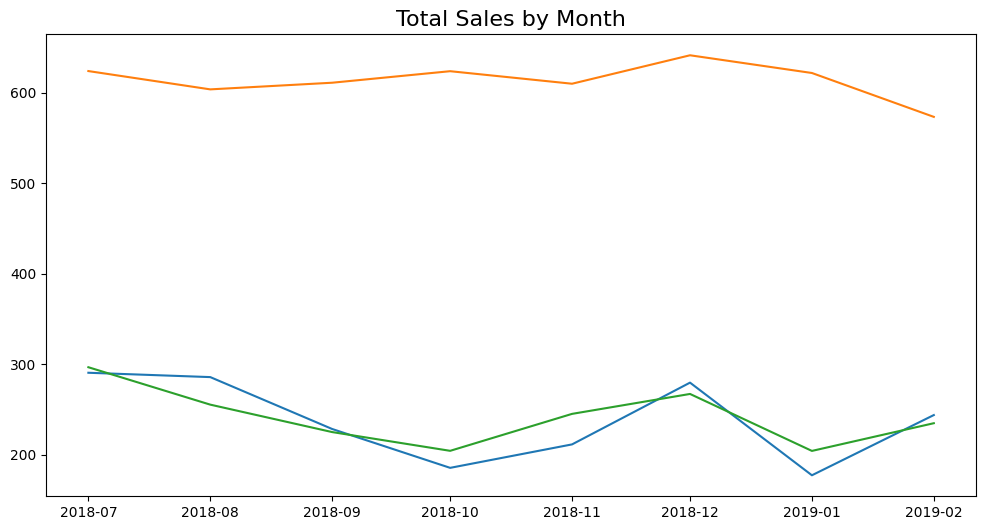

In [11]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Filter for data before March 2019 and aggregate total sales by YEARMONTH and Store_type
past_sales = measure_over_time[measure_over_time['YEARMONTH'] < 201903]
past_sales = past_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Step 3: Convert YEARMONTH to a datetime column
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Step 4: Plot the trends
plt.figure(figsize=(12, 6))
for store_type, group_data in past_sales.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['totSales'], label=store_type)

plt.title("Total Sales by Month", fontsize=16)
plt

Next, number of customers

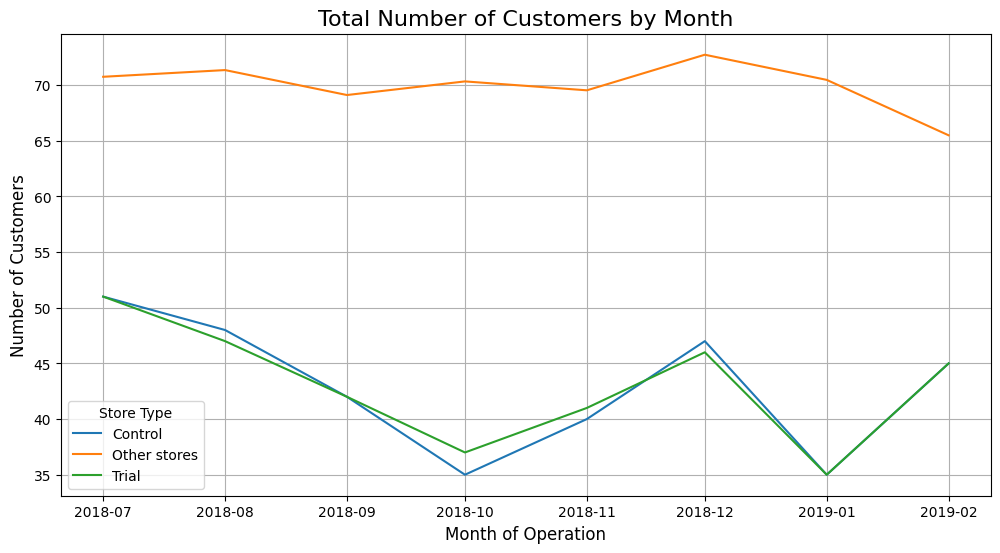

In [12]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Filter for data before March 2019 and aggregate the number of customers by YEARMONTH and Store_type
past_customers = measure_over_time[measure_over_time['YEARMONTH'] < 201903]
past_customers = past_customers.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Step 3: Convert YEARMONTH to a datetime column
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Step 4: Plot the trends
plt.figure(figsize=(12, 6))
for store_type, group_data in past_customers.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['nCustomers'], label=store_type)

plt.title("Total Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

## Assessment of trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall chip sales.

We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

In [13]:
# Step 1: Calculate the scaling factor for control store sales
trial_store_sales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['totSales'].sum()

control_store_sales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['totSales'].sum()

scaling_factor_for_control_sales = trial_store_sales / control_store_sales

# Step 2: Apply the scaling factor to control store sales in the main dataset
measure_over_time['controlSales'] = measure_over_time.apply(
    lambda row: row['totSales'] * scaling_factor_for_control_sales 
    if row['STORE_NBR'] == control_store else row['totSales'], axis=1
)

Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [14]:
# Step 1: Merge scaled control sales and trial store sales on YEARMONTH
merged_sales = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store, ['YEARMONTH', 'totSales']
].merge(
    measure_over_time.loc[
        measure_over_time['STORE_NBR'] == control_store, ['YEARMONTH', 'controlSales']
    ],
    on='YEARMONTH',
    how='inner'
)

# Step 2: Calculate the percentage difference
merged_sales['percentageDiff'] = abs(merged_sales['controlSales'] - merged_sales['totSales']) / merged_sales['controlSales']

Let’s see if the difference is significant!

In [15]:
# Step 1: Calculate the standard deviation of percentage differences in the pre-trial period
pre_trial_percentage_diff = merged_sales[merged_sales['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_percentage_diff, ddof=1)  # ddof=1 for sample standard deviation

# Step 2: Degrees of freedom for the pre-trial period
degrees_of_freedom = len(pre_trial_percentage_diff) - 1

# Step 3: Calculate t-values for the trial period
merged_sales['tValue'] = (merged_sales['percentageDiff'] - 0) / std_dev

# Step 4: Add TransactionMonth as a datetime column
merged_sales['TransactionMonth'] = pd.to_datetime(
    merged_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Filter for the trial period
trial_t_values = merged_sales[
    (merged_sales['YEARMONTH'] > 201901) & (merged_sales['YEARMONTH'] < 201905)
][['TransactionMonth', 'tValue']]

# Step 5: Find the 95th percentile of the t-distribution for the given degrees of freedom
t_critical = t.ppf(0.95, df=degrees_of_freedom)


# Display the critical t-value for comparison
t_critical


np.float64(1.9431802805153022)

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

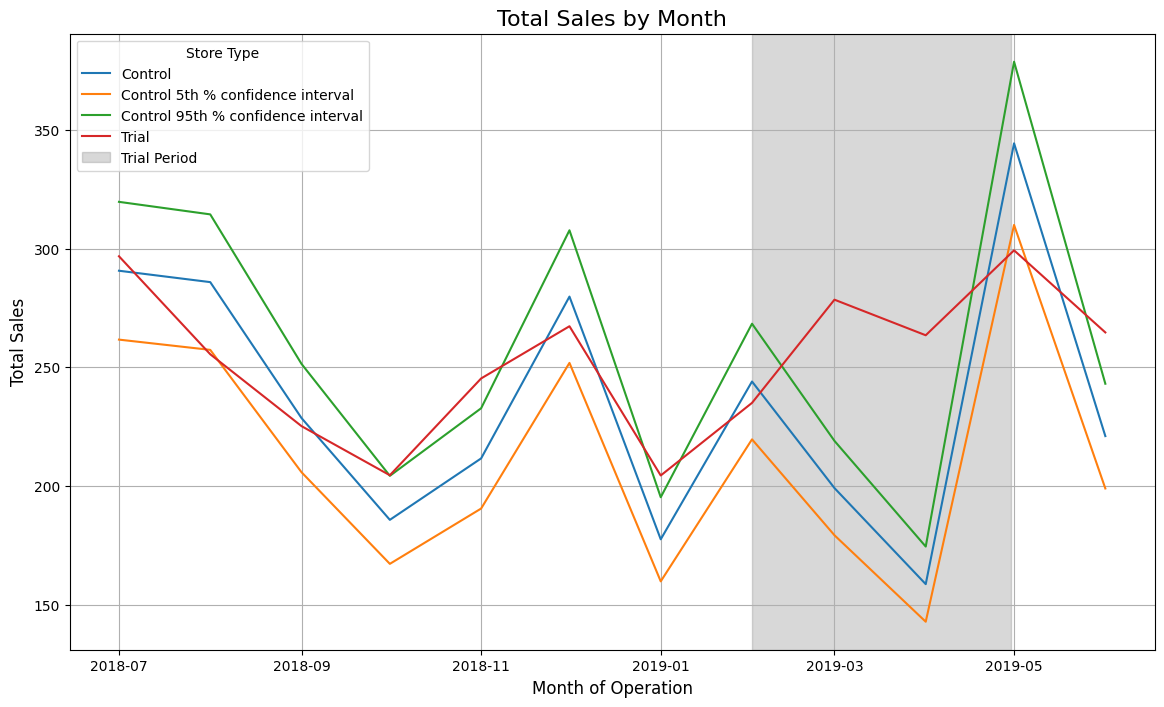

In [16]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Aggregate total sales by month and store type
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Add TransactionMonth as a datetime column
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Filter for trial and control stores
trial_and_control_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

# Step 3: Calculate the 95th and 5th percentiles for the control store sales
control_95th = trial_and_control_sales[trial_and_control_sales['Store_type'] == 'Control'].copy()
control_95th['totSales'] = control_95th['totSales'] * (1 + std_dev * 2)
control_95th['Store_type'] = 'Control 95th % confidence interval'

control_5th = trial_and_control_sales[trial_and_control_sales['Store_type'] == 'Control'].copy()
control_5th['totSales'] = control_5th['totSales'] * (1 - std_dev * 2)
control_5th['Store_type'] = 'Control 5th % confidence interval'

# Combine data
trial_assessment = pd.concat([trial_and_control_sales, control_95th, control_5th])

# Step 4: Plot the data
plt.figure(figsize=(14, 8))
for store_type, group_data in trial_assessment.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['totSales'], label=store_type)

# Highlight trial period (Feb 2019 - April 2019)
plt.axvspan(
    pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), 
    color='grey', alpha=0.3, label='Trial Period'
)

# Add labels and legend
plt.title("Total Sales by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

Let’s have a look at assessing this for number of customers as well.

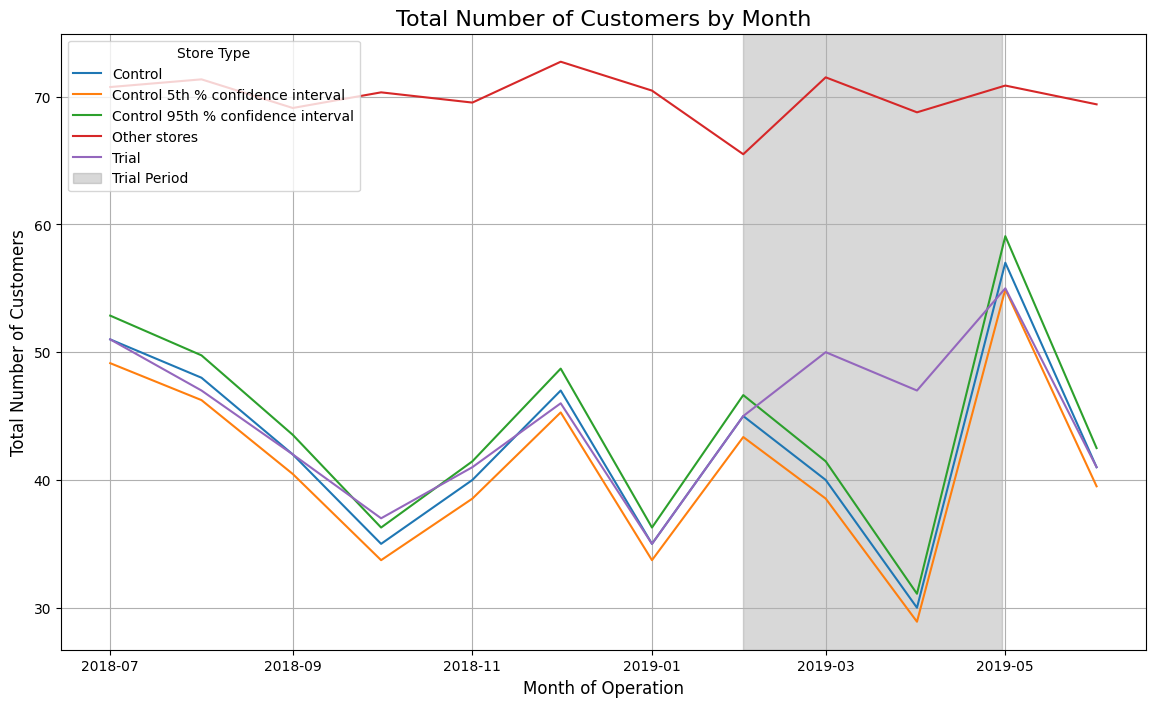

In [17]:
# Step 1: Scale pre-trial control customers to match pre-trial trial store customers
trial_customers = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['nCustomers'].sum()

control_customers = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['nCustomers'].sum()

scaling_factor_for_control_cust = trial_customers / control_customers

# Step 2: Apply the scaling factor to control store customers
measure_over_time['controlCustomers'] = measure_over_time.apply(
    lambda row: row['nCustomers'] * scaling_factor_for_control_cust 
    if row['STORE_NBR'] == control_store else row['nCustomers'], axis=1
)

measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 3: Calculate the percentage difference between scaled control customers and trial customers
customer_percentage_diff = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store, ['YEARMONTH', 'nCustomers']
].merge(
    measure_over_time.loc[
        measure_over_time['STORE_NBR'] == control_store, ['YEARMONTH', 'controlCustomers']
    ],
    on='YEARMONTH',
    how='inner'
)

customer_percentage_diff['percentageDiff'] = abs(
    customer_percentage_diff['controlCustomers'] - customer_percentage_diff['nCustomers']
) / customer_percentage_diff['controlCustomers']

# Step 4: Calculate standard deviation of percentage differences in the pre-trial period
std_dev_cust = np.std(
    customer_percentage_diff[customer_percentage_diff['YEARMONTH'] < 201902]['percentageDiff'],
    ddof=1
)

# Step 5: Aggregate data for plotting
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Calculate the 95th and 5th percentiles for control store customers
control_95th_cust = past_customers[past_customers['Store_type'] == 'Control'].copy()
control_95th_cust['nCustomers'] = control_95th_cust['nCustomers'] * (1 + std_dev_cust * 2)
control_95th_cust['Store_type'] = 'Control 95th % confidence interval'

control_5th_cust = past_customers[past_customers['Store_type'] == 'Control'].copy()
control_5th_cust['nCustomers'] = control_5th_cust['nCustomers'] * (1 - std_dev_cust * 2)
control_5th_cust['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trial_assessment_cust = pd.concat([past_customers, control_95th_cust, control_5th_cust])

# Step 6: Plot the data
plt.figure(figsize=(14, 8))
for store_type, group_data in trial_assessment_cust.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['nCustomers'], label=store_type)

# Highlight trial period (Feb 2019 - April 2019)
plt.axvspan(
    pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), 
    color='grey', alpha=0.3, label='Trial Period'
)

# Add labels and legend
plt.title("Total Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Number of Customers", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.

### Trial store 86

In [18]:
# Step 1: Calculate measures over time for each store
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / data.loc[x.index, 'TXN_ID'].nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Step 2: Calculate correlation for sales and number of customers for trial store 86
trial_store = 86
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Step 3: Calculate magnitude distance for sales and number of customers for trial store 86
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

# Step 4: Create combined scores composed of correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (
    score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)
)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (
    score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
)

# Step 5: Combine scores across drivers
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = (
    score_control['scoreNSales'] * 0.5 + score_control['scoreNCust'] * 0.5
)

# Step 6: Select the control store for trial store 86
control_store_selection = score_control[score_control['Store1'] == trial_store]
control_store_selection = control_store_selection[control_store_selection['Store2'] != trial_store]
control_store_selection = control_store_selection.sort_values(by='finalControlScore', ascending=False)

control_store = control_store_selection.iloc[0]['Store2'] if not control_store_selection.empty else None

# The control store for trial store 86 has been selected
control_store 

np.float64(155.0)

Looks like store 155 will be a control store for trial store 86. 

Again, let’s check visually if the drivers are indeed similar in the period before the trial.

We’ll look at total sales first.

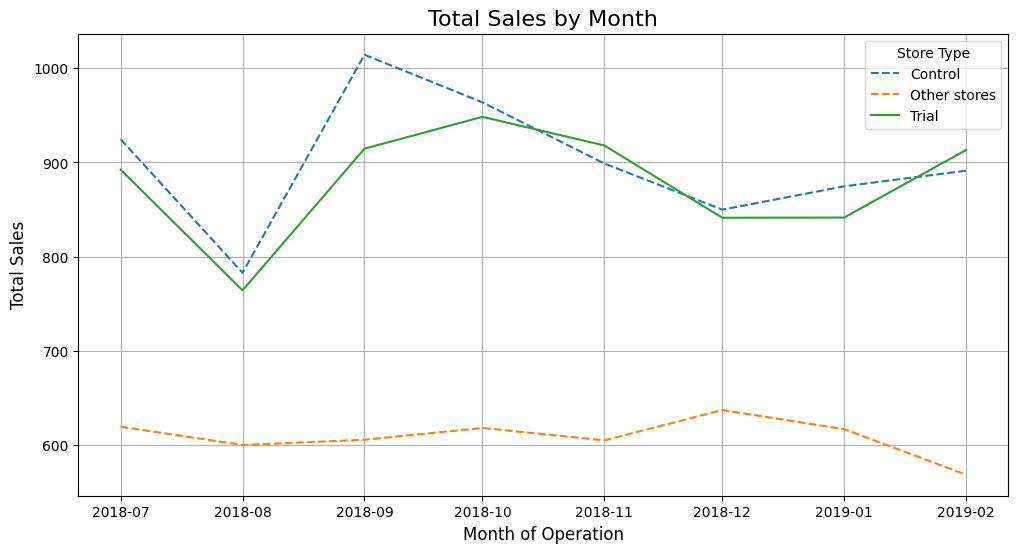

In [19]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Aggregate total sales by month and store type
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Step 3: Convert YEARMONTH to a datetime column
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Step 4: Filter for pre-trial period
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Step 5: Plot the trends
plt.figure(figsize=(12, 6))
for store_type, group_data in past_sales.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['totSales'], label=store_type, linestyle='--' if store_type != 'Trial' else '-')

# Add labels and legend
plt.title("Total Sales by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

Great, sales are trending in a similar way. 

Next, number of customers

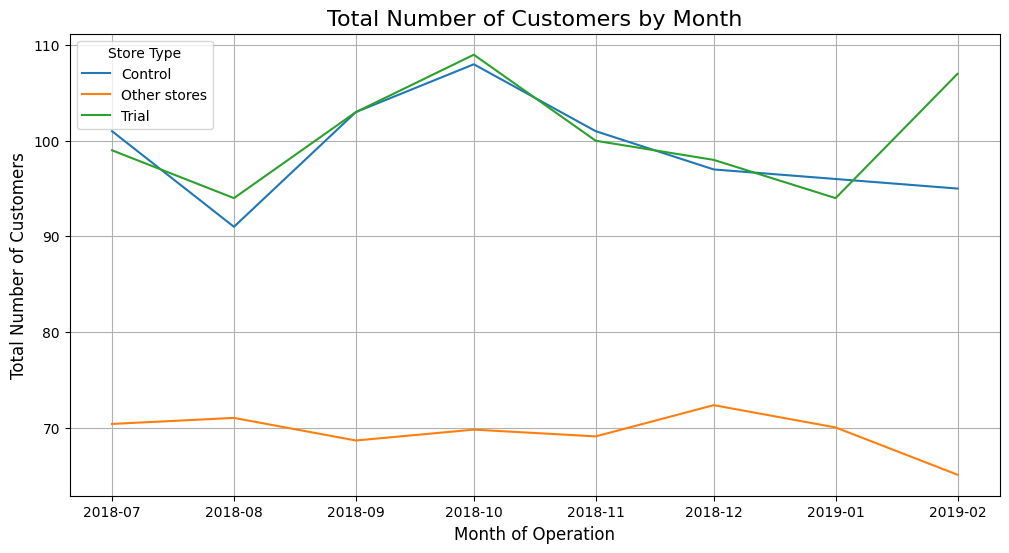

In [20]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Aggregate number of customers by month and store type
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Step 3: Convert YEARMONTH to a datetime column
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Step 4: Filter for pre-trial period
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

# Step 5: Plot the trends
plt.figure(figsize=(12, 6))
for store_type, group_data in past_customers.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['nCustomers'], label=store_type)

# Add labels and legend
plt.title("Total Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Number of Customers", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

Good, the trend in number of customers is also similar. 

Let’s now assess the impact of the trial on sales.

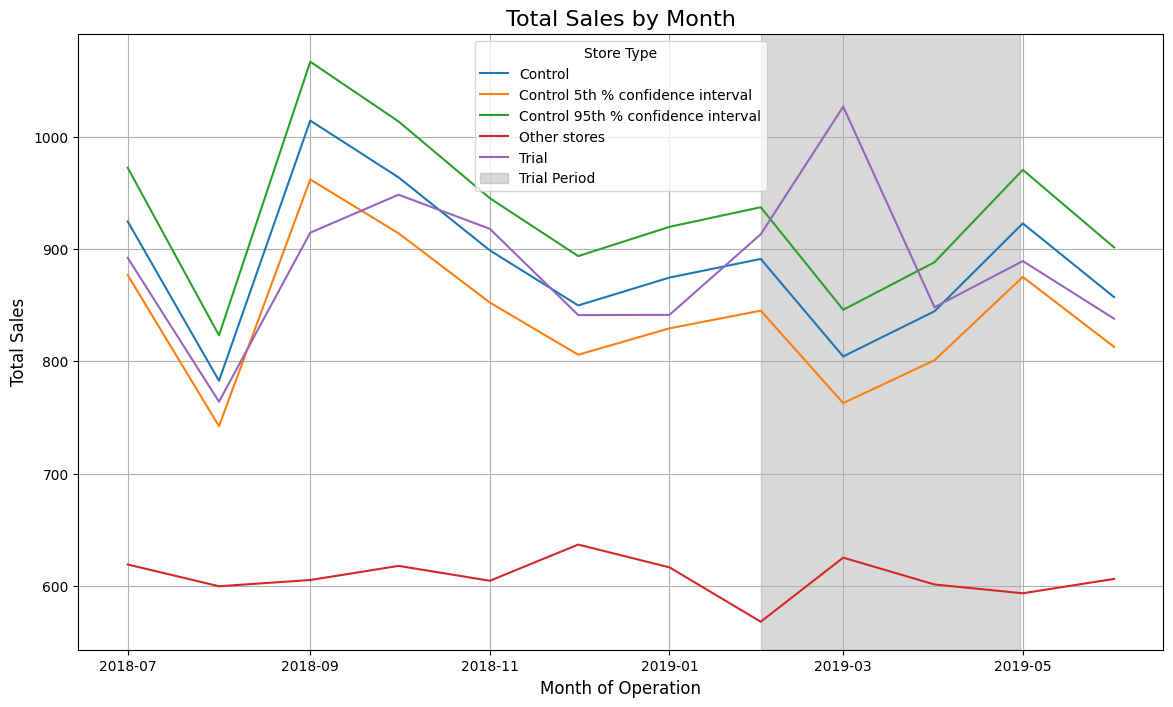

In [21]:
# Step 1: Scale pre-trial control sales to match pre-trial trial store sales
trial_totSales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['totSales'].sum()

control_totSales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['totSales'].sum()

scaling_factor_for_control_sales = trial_totSales / control_totSales

# Step 2: Apply the scaling factor to control store sales
measure_over_time['controlSales'] = measure_over_time.apply(
    lambda row: row['totSales'] * scaling_factor_for_control_sales 
    if row['STORE_NBR'] == control_store else row['totSales'], axis=1
)

# Step 3: Calculate the percentage difference between scaled control sales and trial sales
percentage_diff = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store, ['YEARMONTH', 'totSales']
].merge(
    measure_over_time.loc[
        measure_over_time['STORE_NBR'] == control_store, ['YEARMONTH', 'controlSales']
    ],
    on='YEARMONTH',
    how='inner'
)

percentage_diff['percentageDiff'] = abs(
    percentage_diff['controlSales'] - percentage_diff['totSales']
) / percentage_diff['controlSales']

# Step 4: Calculate standard deviation of percentage differences in the pre-trial period
std_dev = np.std(
    percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'],
    ddof=1
)

# Step 5: Aggregate data for plotting
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Calculate the 95th and 5th percentiles for control store sales
control_95th = past_sales[past_sales['Store_type'] == 'Control'].copy()
control_95th['totSales'] = control_95th['totSales'] * (1 + std_dev * 2)
control_95th['Store_type'] = 'Control 95th % confidence interval'

control_5th = past_sales[past_sales['Store_type'] == 'Control'].copy()
control_5th['totSales'] = control_5th['totSales'] * (1 - std_dev * 2)
control_5th['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trial_assessment = pd.concat([past_sales, control_95th, control_5th])

# Step 6: Plot the data
plt.figure(figsize=(14, 8))
for store_type, group_data in trial_assessment.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['totSales'], label=store_type)

# Highlight trial period (Feb 2019 - April 2019)
plt.axvspan(
    pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), 
    color='grey', alpha=0.3, label='Trial Period'
)

# Add labels and legend
plt.title("Total Sales by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

Let’s have a look at assessing this for number of customers as well.

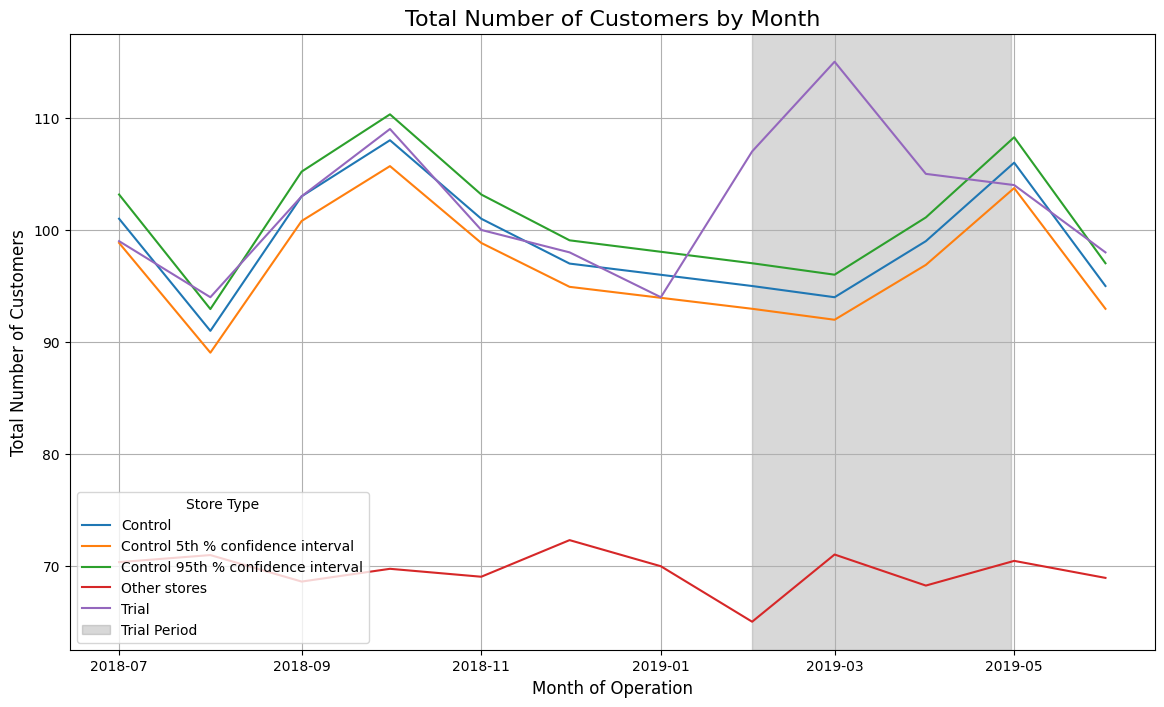

In [22]:
# Step 1: Scale pre-trial control customers to match pre-trial trial store customers
trial_customers = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['nCustomers'].sum()

control_customers = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['nCustomers'].sum()

scaling_factor_for_control_cust = trial_customers / control_customers

# Step 2: Apply the scaling factor to control store customers
measure_over_time['controlCustomers'] = measure_over_time.apply(
    lambda row: row['nCustomers'] * scaling_factor_for_control_cust 
    if row['STORE_NBR'] == control_store else row['nCustomers'], axis=1
)

measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 3: Calculate the percentage difference between scaled control customers and trial customers
customer_percentage_diff = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store, ['YEARMONTH', 'nCustomers']
].merge(
    measure_over_time.loc[
        measure_over_time['STORE_NBR'] == control_store, ['YEARMONTH', 'controlCustomers']
    ],
    on='YEARMONTH',
    how='inner'
)

customer_percentage_diff['percentageDiff'] = abs(
    customer_percentage_diff['controlCustomers'] - customer_percentage_diff['nCustomers']
) / customer_percentage_diff['controlCustomers']

# Step 4: Calculate standard deviation of percentage differences in the pre-trial period
std_dev_cust = np.std(
    customer_percentage_diff[customer_percentage_diff['YEARMONTH'] < 201902]['percentageDiff'],
    ddof=1
)

# Step 5: Aggregate data for plotting
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Calculate the 95th and 5th percentiles for control store customers
control_95th_cust = past_customers[past_customers['Store_type'] == 'Control'].copy()
control_95th_cust['nCustomers'] = control_95th_cust['nCustomers'] * (1 + std_dev_cust * 2)
control_95th_cust['Store_type'] = 'Control 95th % confidence interval'

control_5th_cust = past_customers[past_customers['Store_type'] == 'Control'].copy()
control_5th_cust['nCustomers'] = control_5th_cust['nCustomers'] * (1 - std_dev_cust * 2)
control_5th_cust['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trial_assessment_cust = pd.concat([past_customers, control_95th_cust, control_5th_cust])

# Step 6: Plot the data
plt.figure(figsize=(14, 8))
for store_type, group_data in trial_assessment_cust.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['nCustomers'], label=store_type)

# Highlight trial period (Feb 2019 - April 2019)
plt.axvspan(
    pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), 
    color='grey', alpha=0.3, label='Trial Period'
)

# Add labels and legend
plt.title("Total Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Number of Customers", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. 

We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

### Trial Store 88

In [23]:
# Step 1: Calculate measures over time for each store
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / data.loc[x.index, 'TXN_ID'].nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Step 2: Calculate correlation for sales and number of customers for trial store 88
trial_store = 88
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Step 3: Calculate magnitude distance for sales and number of customers for trial store 88
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

# Step 4: Create combined scores composed of correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (
    score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)
)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (
    score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
)

# Step 5: Combine scores across drivers
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = (
    score_control['scoreNSales'] * 0.5 + score_control['scoreNCust'] * 0.5
)

# Step 6: Select the control store for trial store 88
control_store_selection = score_control[score_control['Store1'] == trial_store]
control_store_selection = control_store_selection[control_store_selection['Store2'] != trial_store]
control_store_selection = control_store_selection.sort_values(by='finalControlScore', ascending=False)

control_store = control_store_selection.iloc[0]['Store2'] if not control_store_selection.empty else None

# The control store for trial store 88 has been selected
control_store

np.float64(237.0)

We’ve now found store 237 to be a suitable control store for trial store 88.

Again, let’s check visually if the drivers are indeed similar in the period before the trial. 

We’ll look at total sales first.

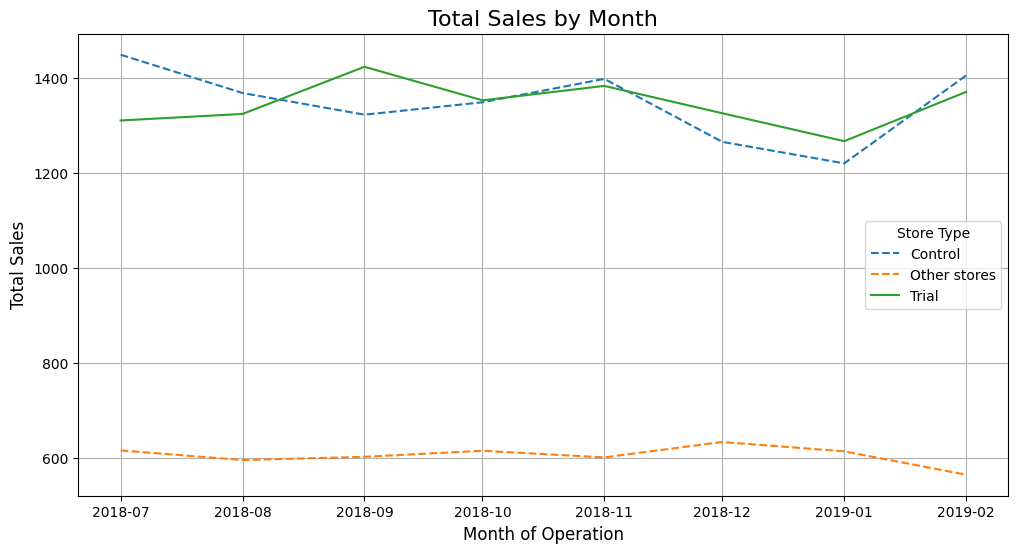

In [24]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Aggregate total sales by month and store type
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Step 3: Convert YEARMONTH to a datetime column
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Step 4: Filter for pre-trial period
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Step 5: Plot the trends
plt.figure(figsize=(12, 6))
for store_type, group_data in past_sales.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['totSales'], label=store_type, linestyle='--' if store_type != 'Trial' else '-')

# Add labels and legend
plt.title("Total Sales by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

Great, the trial and control stores have similar total sales. 

Next, number of customers.

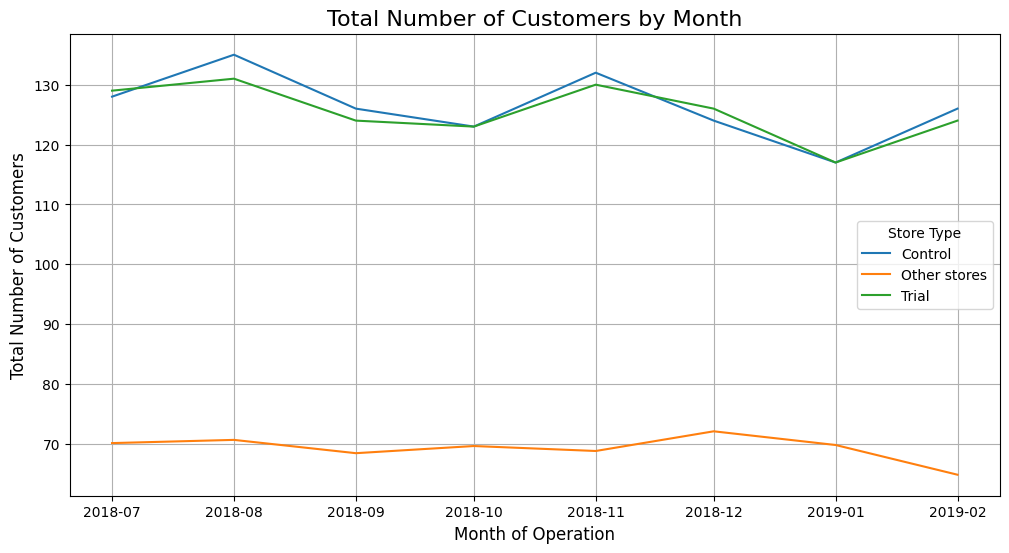

In [25]:
# Step 1: Mark stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 2: Aggregate number of customers by month and store type
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()

# Step 3: Convert YEARMONTH to a datetime column
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Step 4: Filter for pre-trial period
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

# Step 5: Plot the trends
plt.figure(figsize=(12, 6))
for store_type, group_data in past_customers.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['nCustomers'], label=store_type)

# Add labels and legend
plt.title("Total Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Number of Customers", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

Total number of customers of the control and trial stores are also similar. 

Let’s now assess the impact of the trial on sales.

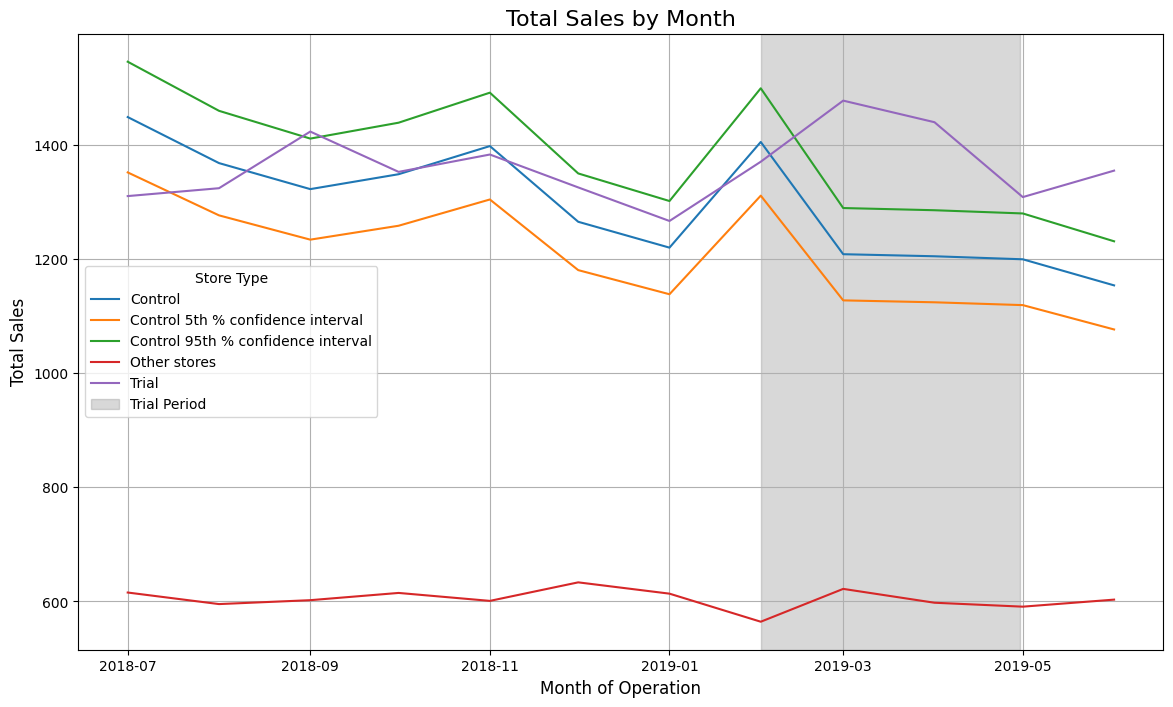

In [26]:
# Step 1: Scale pre-trial control sales to match pre-trial trial store sales
trial_totSales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['totSales'].sum()

control_totSales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['totSales'].sum()

scaling_factor_for_control_sales = trial_totSales / control_totSales

# Step 2: Apply the scaling factor to control store sales
measure_over_time['controlSales'] = measure_over_time.apply(
    lambda row: row['totSales'] * scaling_factor_for_control_sales 
    if row['STORE_NBR'] == control_store else row['totSales'], axis=1
)

# Step 3: Calculate the percentage difference between scaled control sales and trial sales
percentage_diff = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store, ['YEARMONTH', 'totSales']
].merge(
    measure_over_time.loc[
        measure_over_time['STORE_NBR'] == control_store, ['YEARMONTH', 'controlSales']
    ],
    on='YEARMONTH',
    how='inner'
)

percentage_diff['percentageDiff'] = abs(
    percentage_diff['controlSales'] - percentage_diff['totSales']
) / percentage_diff['controlSales']

# Step 4: Calculate standard deviation of percentage differences in the pre-trial period
std_dev = np.std(
    percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'],
    ddof=1
)

# Step 5: Aggregate data for plotting
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Calculate the 95th and 5th percentiles for control store sales
control_95th = past_sales[past_sales['Store_type'] == 'Control'].copy()
control_95th['totSales'] = control_95th['totSales'] * (1 + std_dev * 2)
control_95th['Store_type'] = 'Control 95th % confidence interval'

control_5th = past_sales[past_sales['Store_type'] == 'Control'].copy()
control_5th['totSales'] = control_5th['totSales'] * (1 - std_dev * 2)
control_5th['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trial_assessment = pd.concat([past_sales, control_95th, control_5th])

# Step 6: Plot the data
plt.figure(figsize=(14, 8))
for store_type, group_data in trial_assessment.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['totSales'], label=store_type)

# Highlight trial period (Feb 2019 - April 2019)
plt.axvspan(
    pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), 
    color='grey', alpha=0.3, label='Trial Period'
)

# Add labels and legend
plt.title("Total Sales by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

Let’s have a look at assessing this for number of customers as well.

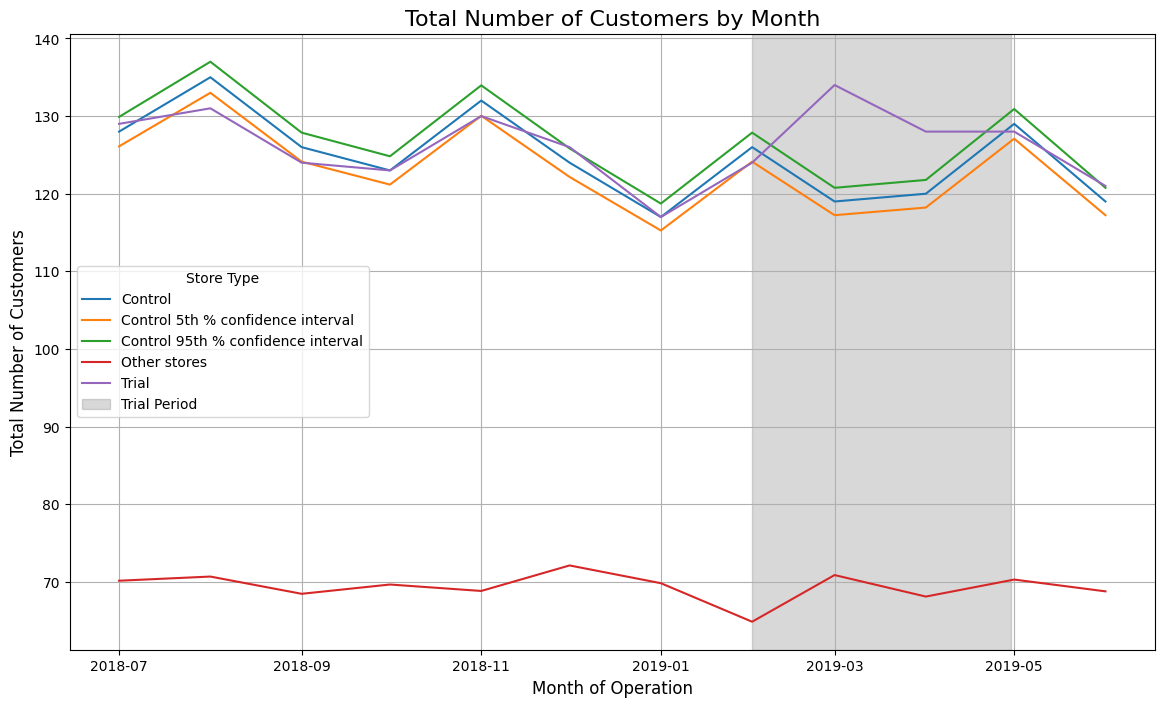

In [27]:
# Step 1: Scale pre-trial control customers to match pre-trial trial store customers
trial_customers = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['nCustomers'].sum()

control_customers = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store) & 
    (pre_trial_measures['YEARMONTH'] < 201902)
]['nCustomers'].sum()

scaling_factor_for_control_cust = trial_customers / control_customers

# Step 2: Apply the scaling factor to control store customers
measure_over_time['controlCustomers'] = measure_over_time.apply(
    lambda row: row['nCustomers'] * scaling_factor_for_control_cust 
    if row['STORE_NBR'] == control_store else row['nCustomers'], axis=1
)

measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Step 3: Calculate the percentage difference between scaled control customers and trial customers
customer_percentage_diff = measure_over_time.loc[
    measure_over_time['STORE_NBR'] == trial_store, ['YEARMONTH', 'nCustomers']
].merge(
    measure_over_time.loc[
        measure_over_time['STORE_NBR'] == control_store, ['YEARMONTH', 'controlCustomers']
    ],
    on='YEARMONTH',
    how='inner'
)

customer_percentage_diff['percentageDiff'] = abs(
    customer_percentage_diff['controlCustomers'] - customer_percentage_diff['nCustomers']
) / customer_percentage_diff['controlCustomers']

# Step 4: Calculate standard deviation of percentage differences in the pre-trial period
std_dev_cust = np.std(
    customer_percentage_diff[customer_percentage_diff['YEARMONTH'] < 201902]['percentageDiff'],
    ddof=1
)

# Step 5: Aggregate data for plotting
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Calculate the 95th and 5th percentiles for control store customers
control_95th_cust = past_customers[past_customers['Store_type'] == 'Control'].copy()
control_95th_cust['nCustomers'] = control_95th_cust['nCustomers'] * (1 + std_dev_cust * 2)
control_95th_cust['Store_type'] = 'Control 95th % confidence interval'

control_5th_cust = past_customers[past_customers['Store_type'] == 'Control'].copy()
control_5th_cust['nCustomers'] = control_5th_cust['nCustomers'] * (1 - std_dev_cust * 2)
control_5th_cust['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trial_assessment_cust = pd.concat([past_customers, control_95th_cust, control_5th_cust])

# Step 6: Plot the data
plt.figure(figsize=(14, 8))
for store_type, group_data in trial_assessment_cust.groupby('Store_type'):
    plt.plot(group_data['TransactionMonth'], group_data['nCustomers'], label=store_type)

# Highlight trial period (Feb 2019 - April 2019)
plt.axvspan(
    pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), 
    color='grey', alpha=0.3, label='Trial Period'
)

# Add labels and legend
plt.title("Total Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=12)
plt.ylabel("Total Number of Customers", fontsize=12)
plt.legend(title="Store Type")
plt.grid(True)
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

## Conclusion

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. 

We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.